Preprocessing: https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.259.3762&rep=rep1&type=pdf

In [1]:
# All the libraries used
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import time
import random
import math

from scipy.ndimage import imread # Need to use scipy 1.1.0 to run imread
import scipy.ndimage
from scipy.misc import imresize
import scipy 
import seaborn as sns

## Loading dataset1

In [3]:
path1 = "/Users/haley/Desktop/CMPE 255/Rentinal Classification/gaussian_diabetic_retino/gaussian_filtered_images/gaussian_filtered_images/"
level = ["Mild","Moderate","No_DR","Proliferate_DR","Severe"]
file_id = []
gauss_x = []
for i in level:    
    for dirName, subdirList, fileList in os.walk(path1+i):
        # Randomly pick k images from each level
        random_images = random.choices(fileList,k=190)
        for filename in random_images: 
            file_id.append(filename)
            gauss_x.append(os.path.join(dirName,filename))   

In [4]:
len(file_id) # Total number of data points

950

In [5]:
target1 = pd.read_csv("gaussian_diabetic_retino/train.csv")
target1.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [6]:
target1['diagnosis'].value_counts()

0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64

In [8]:
# To get the target values corresponding to given target csv file
gauss_y = []
for i in range(len(file_id)):
    code = file_id[i][:-4] # Slice to get rid of .png at the end of str
    label = target1['diagnosis'][target1['id_code'] == code]
    gauss_y.append(int(label))
gauss_y = np.array(gauss_y)

## Loading dataset2

In [9]:
path2 = "resized_diabetic_2015/resized_train_cropped/resized_train_cropped"  
target2 = pd.read_csv("resized_diabetic_2015/trainLabels_cropped.csv")
target2.sample(10)

,Unnamed: 0,Unnamed: 0.1,image,level
27040,27040,27055,34245_right,0
30941,30941,30957,39126_right,0
18558,18558,18570,23411_left,0
10664,10664,10671,13436_right,0
30842,30842,30858,39014_left,0
26251,26251,26266,33256_left,0
32137,32137,32153,40606_right,0
14976,14976,14985,18760_right,0
7508,7508,7512,9478_left,1
26463,26463,26478,33519_left,2


In [10]:
level_0 = target2["image"][target2['level'] == 0].tolist()
level_1 = target2["image"][target2['level'] == 1].tolist()
level_2 = target2["image"][target2['level'] == 2].tolist()
level_3 = target2["image"][target2['level'] == 3].tolist()
level_4 = target2["image"][target2['level'] == 4].tolist()

K = 708
level_0 = random.choices(level_0,k=K)
level_1 = random.choices(level_1,k=K)
level_2 = random.choices(level_2,k=K)
level_3 = random.choices(level_3,k=K)
level_4 = random.choices(level_4,k=K)

In [11]:
# Creating X and Y 
resized_x = np.concatenate((level_0,level_1,level_2,level_3,level_4))
resized_y = np.concatenate((np.zeros(K),np.ones(K),np.ones(K)*2,np.ones(K)*3,np.ones(K)*4))

## Image to Array

In [12]:
# 0. Read the data1 into Numpy
n1 = len(gauss_x)
one = np.zeros((n1,224,224))

# 0.5 Transfer All of the Data into array
print('===== READING DATA ========')
for file_index in range(n1):
    one[file_index,:,:]   = imresize(imread(gauss_x[file_index],mode='F',flatten=True),(224,224))
print('===== Done READING DATA ========')

===== READING DATA ========


/Users/haley/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  
/Users/haley/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


===== Done READING DATA ========


In [19]:
# 0. Read the data2 into Numpy
n2 = len(resized_x)
pixels = 224
two = np.zeros((n2,pixels,pixels))

for file_name in range(n2):
    image_path = path2+"/"+resized_x[file_name]+".jpeg"
    two[file_name,:,:]   = cv2.resize(cv2.imread(image_path,0),(224,224))


In [15]:
Y = np.concatenate((gauss_y,resized_y))

In [14]:
whole = np.concatenate((one,two))

In [17]:
# Normalization
whole = (whole - np.mean(whole)) / math.sqrt(np.var(whole))

## Applying Gaussian filter with Laplacian

* Read about how Laplacian of Gaussian works here: https://homepages.inf.ed.ac.uk/rbf/HIPR2/log.htm
* Using cv2 to apply this technique: 
https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_filtering/py_filtering.html

In [35]:
# LoG (Smooth) Function
data_array = []
for x in range(len(whole)):
    s = 1.75
    temp = scipy.ndimage.filters.gaussian_filter(
        whole[x,:,:],
        sigma = s
        )
    
    lap_kernel = np.array([
        [0,1,0],
        [1,-4,1],
        [0,1,0]
    ])

    result = cv2.filter2D(temp,-1,lap_kernel)
    data_array.append(result)
#     plt.axis('off')
#     plt.imshow(result,cmap='gray')
#     plt.savefig("LoG_images/"+ str(x) + '.png',bbox_inches='tight')
#     plt.show()
# -- end code --

Example

In [ ]:
plt.axis('off')
plt.imshow(one[-1],cmap='gray')
plt.show()

In [ ]:
# Original Picture
hist,bins = np.histogram(one[-1].flatten(),256,[0,256])

cdf = hist.cumsum()
cdf_normalized = cdf * hist.max()/ cdf.max()

plt.plot(cdf_normalized, color = 'b')
plt.hist(one[-1].flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.show()

In [ ]:
plt.axis('off')
plt.imshow(result,cmap='gray')
plt.show()

In [ ]:
# Histogram after LoG
hist,bins = np.histogram(result.flatten(),12,[0,12])

cdf = hist.cumsum()
cdf_normalized = cdf * hist.max()/ cdf.max()

plt.plot(cdf_normalized, color = 'b')
plt.hist(result.flatten(),12,[0,12], color = 'r')
plt.xlim([0,12])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.show()

## Histogram

* Applying Histograms Equalization: 
https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_histograms/py_histogram_equalization/py_histogram_equalization.html
* In-depth lecture on histogram analysis of digital image: https://web.cs.wpi.edu/~emmanuel/courses/cs545/S14/slides/lecture02.pdf

In [ ]:
img = cv2.imread(lstFilesDCM[-1],0)
equ = cv2.equalizeHist(img)
res = np.hstack((img,equ)) #stacking images side-by-side
plt.axis('off')
plt.imshow(res,cmap='gray')
plt.show()

In [ ]:
# After equalization
hist,bins = np.histogram(equ,256,[0,256])

cdf = hist.cumsum()
cdf_normalized = cdf * hist.max()/ cdf.max()

plt.plot(cdf_normalized, color = 'b')
plt.hist(one[-1].flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.show()

In [ ]:
hist_data = []
for i in lstFilesDCM:
    img = cv2.imread(i,0)
    equ = cv2.equalizeHist(img)
    hist_data.append(equ)
    
hist_data = np.array(hist_data).flatten().reshape(n,-1)

In [ ]:
# Using Histogram Equalization set
X_train, X_test, y_train, y_test = train_test_split(hist_data,y, test_size=0.3, random_state=42)
print('Training data and target sizes: \n{}, {}'.format(X_train.shape,y_train.shape))
print('Test data and target sizes: \n{}, {}'.format(X_test.shape,y_test.shape))

## Reshaping and splitting dataset

In [39]:
data_array = norm_data.flatten().reshape(n1+n2,-1)

In [40]:
data_array.shape

(4490, 50176)

In [41]:
Y = np.concatenate((gauss_y,resized_y))

In [42]:
X_train, X_test, y_train, y_test = train_test_split(data_array,Y, test_size=0.3, random_state=42)
print('Training data and target sizes: \n{}, {}'.format(X_train.shape,y_train.shape))
print('Test data and target sizes: \n{}, {}'.format(X_test.shape,y_test.shape))

Training data and target sizes: 
(3143, 50176), (3143,)
Test data and target sizes: 
(1347, 50176), (1347,)


## Data Preprocessing, Training and Testing

**KMeans**

In [51]:
# Preprocessing with KMeans
# Rule of thumb for picking K
#k = 30
k = math.sqrt(X_train.shape[0]/2)
kmnist_kmeans = KMeans(n_clusters=int(k), max_iter = 1000).fit(X_train)
X_train_cluster = kmnist_kmeans.transform(X_train)
X_test_cluster = kmnist_kmeans.transform(X_test)
print("Reduced Shape:", X_train_cluster.shape)

Reduced Shape: (3143, 39)


w/SVM

In [52]:
kmean_svm = svm.SVC(gamma=0.001,class_weight='balanced')
starting_time = time.process_time()
kmean_svm.fit(X_train_cluster,y_train)
print("Data fitting takes", time.process_time() - starting_time, "seconds")
print("Testing Accuracy", kmean_svm.score(X_test_cluster, y_test))

Data fitting takes 2.2962039999997614 seconds
Testing Accuracy 0.47216035634743875


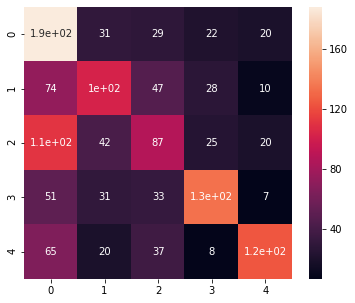

              precision    recall  f1-score   support

         0.0       0.38      0.65      0.48       290
         1.0       0.45      0.39      0.42       262
         2.0       0.37      0.31      0.34       285
         3.0       0.62      0.52      0.57       256
         4.0       0.69      0.49      0.57       254

    accuracy                           0.47      1347
   macro avg       0.50      0.47      0.48      1347
weighted avg       0.50      0.47      0.47      1347



In [53]:
y_pred = kmean_svm.predict(X_test_cluster)
f, ax = plt.subplots(figsize=(6, 5))
ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
ax.set_ylim(5.0, 0)
plt.show()

print(classification_report(y_test,y_pred))